# Evaluating route distances of taxis in NYC (Histograms)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

* We start by reading the data.

In [2]:
data = pd.read_csv("nyc_taxi_trip_data_sample.csv.zip")

* We have seen how to get an overview of the values ​​of a `DataFrame` via the `describe()` method.

* We can also investigate the values ​​of a specific column by calling the appropriate methods on the `Series` object.

In [3]:
data['trip_distance'].count(), data['trip_distance'].min(), data['trip_distance'].max()

(1731797, 0.0, 950000.0)

* Or even:

In [4]:
data['trip_distance'].mean(), data['trip_distance'].median(), data['trip_distance'].std()

(3.4580053089363254, 1.8, 722.1294512805174)

* If the mean distance is about 3.5 miles and the median is 1.8 miles, what is the typical, or most common, distance of a ride?

In [5]:
data['trip_distance'].mode()

0    1.0
dtype: float64

* And what are the ten most common distances?

* The `value_counts()` method counts each distinct value and lists them in descending order.

* If we wanted ascending order, we would pass the `ascending=True` parameter.

In [6]:
data['trip_distance'].value_counts()

1.00     43414
0.90     38480
0.80     37655
1.10     37448
1.20     36056
         ...  
31.97        1
34.28        1
36.00        1
41.06        1
24.87        1
Name: trip_distance, Length: 3004, dtype: int64

* As we can see, there are thousands of different values.

* Suppose we want to take the ten most common ones.

* We can test with the usual Python syntax.

In [7]:
data['trip_distance'].value_counts()[:10]

1.00     43414
0.90     38480
0.80     37655
1.10     37448
1.20     36056
         ...  
7.20      1357
2.64      1337
0.42      1331
2.61      1320
10.00     1313
Name: trip_distance, Length: 275, dtype: int64

* The result is not what we expected.

* The reason is that it returns us the values ​​until it finds the line with a *label* (label) equal to 10.

* But we just want the first 10 in order, based on their position.

* To select lines based on their position we use `iloc[]`.

In [8]:
data['trip_distance'].value_counts().iloc[:10]

1.0    43414
0.9    38480
0.8    37655
1.1    37448
1.2    36056
0.7    34601
1.3    33994
1.4    32474
1.5    31080
0.6    30361
Name: trip_distance, dtype: int64

* The symmetric of `iloc[]` for tag-based selection is `loc[]` (which as we've seen doesn't produce the result we want in our case).

In [9]:
data['trip_distance'].value_counts().loc[:10]

1.00     43414
0.90     38480
0.80     37655
1.10     37448
1.20     36056
         ...  
7.20      1357
2.64      1337
0.42      1331
2.61      1320
10.00     1313
Name: trip_distance, Length: 275, dtype: int64

* Let's make a diagram to see the distances.

* The chart will be a histogram.

* This can be done directly from pandas.

<AxesSubplot:>

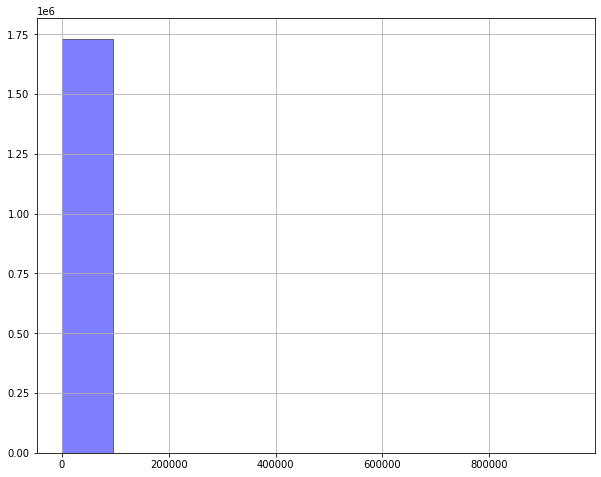

In [18]:
data.trip_distance.hist(color='blue', edgecolor='black', alpha=0.5, figsize=(10, 8))

* The result is probably not what we wanted.

* The reason is that there are routes with outliers, such as 950,000 miles.

* It probably makes sense to limit the histogram to runs from 0 to 10 miles.

* To do this, we need to define the buckets in which we want to collect the data in the histogram.

* We will find 100 values, with NumPy's `linspace()` function, to partition the data with distances from 0 to 10 miles.

In [ ]:
np.linspace(0, 10, 100)

<AxesSubplot:>

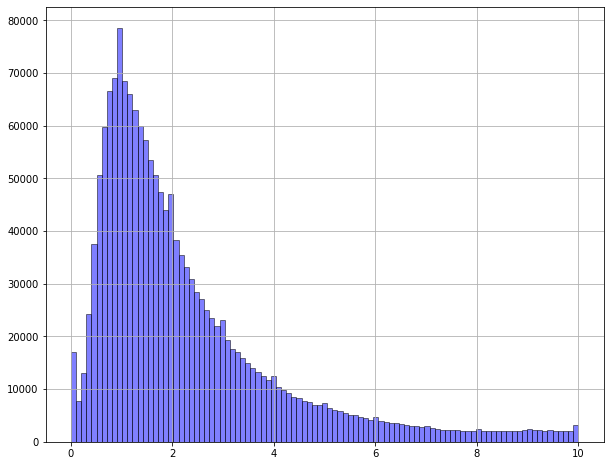

In [12]:
data.trip_distance.hist(bins=np.linspace(0, 10, 100), 
                        color='blue', edgecolor='black', 
                        alpha=0.5, figsize=(10, 8))

* We notice that in the histogram there are some local maxima (peaks).

* To investigate this.

* Let's count how many routes were counted in each bucket (with a small difference that we don't mind here, in the histogram the buckets are right closed-left open, while here it's the other way around).

In [13]:
data['trip_distance'].value_counts(bins=np.linspace(0, 10, 100))

(0.909, 1.01]     78629
(0.808, 0.909]    68974
(1.01, 1.111]     68413
(0.707, 0.808]    66525
(1.111, 1.212]    66112
                  ...  
(9.697, 9.798]     2022
(7.879, 7.98]      2005
(8.485, 8.586]     2005
(8.283, 8.384]     1990
(9.798, 9.899]     1974
Name: trip_distance, Length: 99, dtype: int64

* To locate the vertices, we need to compare the number of runs in each bucket with the corresponding numbers in neighboring buckets.

* We currently have the numbers sorted by the number of routes.

* We should sort them based on the bucket, i.e. the label of each row of the result of `value_counts()`.

* Basically we want to sort based on the index of the result of `value_couns()`.

In [14]:
trip_distance_counts = data['trip_distance'].value_counts(bins=np.linspace(0, 10, 100)).sort_index()
trip_distance_counts

(-0.001, 0.101]    16986
(0.101, 0.202]      7730
(0.202, 0.303]     13104
(0.303, 0.404]     24169
(0.404, 0.505]     37491
                   ...  
(9.495, 9.596]      2137
(9.596, 9.697]      2030
(9.697, 9.798]      2022
(9.798, 9.899]      1974
(9.899, 10.0]       3214
Name: trip_distance, Length: 99, dtype: int64

* So since we have the measurements per bucket, in order from the first bucket (0 to 0.10 miles) to the last (9.90 to 10 miles), we can find the vertices by comparing the neighbors.

* For this purpose we can use the `find_peaks()` function of the [SciPy](https://scipy.org/) library.

* The function returns us the position of the vertices and any additional features we may have requested (and we now ignore).

In [15]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(trip_distance_counts)
peaks

array([ 9, 19, 29, 39, 49, 59, 69, 79, 83, 89, 93])

* Now we can find the buckets corresponding to the vertices.

* We will use `iloc[]` to extract the lines at the vertex positions.

In [16]:
trip_distance_counts.iloc[peaks]

(0.909, 1.01]     78629
(1.919, 2.02]     46971
(2.929, 3.03]     23081
(3.939, 4.04]     12562
(4.949, 5.051]     7332
(5.96, 6.061]      4756
(6.97, 7.071]      3025
(7.98, 8.081]      2343
(8.384, 8.485]     2025
(8.99, 9.091]      2425
(9.394, 9.495]     2153
Name: trip_distance, dtype: int64

* So most peaks correspond to routes with a round distance (1, 2, ..., 8 miles).

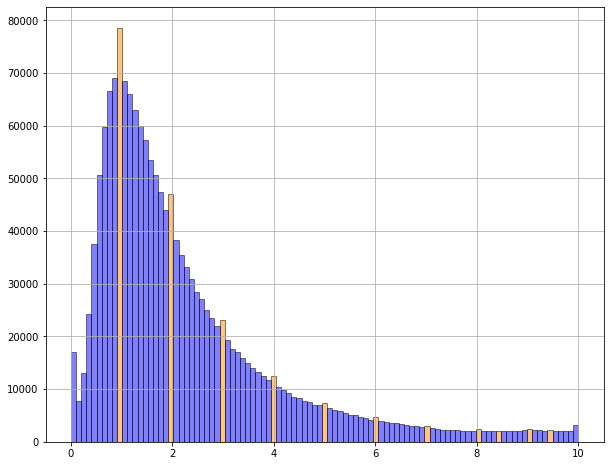

In [19]:
ax = data.trip_distance.hist(bins=np.linspace(0, 10, 100), 
                             color='blue', edgecolor='black', 
                             alpha=0.5, figsize=(10, 8))
for i in peaks:
    ax.patches[i].set_facecolor('darkorange')